# micrograd 
----
* Inspired by Andrej Karpathy's ["The spelled-out intro to neural networks & backpropagation: building micrograd"](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4822s)

* Follow-up *micrograd* exercises to practice can be found in this [notebook](https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing) by Andrej Karpathy.


# Table of Contents
------------------
- [0. Introduction](#0)<br>
    - [0.1. Derivatives: An Overview](#001)
- [1. Micrograd: An Autograd Engine](#1)
- [2. Micrograd: DAG Visualization](#2)
- [3. Micrograd: Backpropagation](#3)
    - [3.1. Manual Backpropagation Example 001: Simple Expression](#301)
    - [3.2. Preview of a Single Optimization Step](#302)
- [4. Micrograd: Neurons](#4)
    - [4.1. Biological Neuron vs. Artificial Neuron](#401)
    - [4.2. Perceptron](#402)
    - [4.3. Activation Functions](#403)
    - [4.4. Manual Backpropagation Example 002: A Neuron](#404)
- [5. Micrograd: Implementing Backward Function for Each Operation](#5)
- [6. Micrograd: Fixing a Backprop Bug when One Node is Used Multiple Times](#6)
    - [6.1. Multivariate Chain Rule for Derivatives](#601)
- [7. Micrograd: Adding More Mathematical Operations](#7)
    - [7.1. Breaking up `tanh` Function into its Parts](#701)
- [8. Micrograd: A `PyTorch` Comparison](#8)
- [9. Micrograd: Building a NN Library (Multi-Layer Perceptron, MLP)](#9)
    - [9.1. Neural Network architectures](#901)
- [10. Micrograd: Creating a Tiny Dataset & Writing the Loss Function](#10)
- [11. Micrograd: Neural Net Parameters](#11)
- [12. Micrograd: Manual Gradient Descent Optimization & Training the MLP](#12)
- [13. Micrograd: Summary](#13)



# Appendix
---------------
## Figures
- [A1. L-R: A Cartoon Diagram of a Biological Neuron & its Mathematical Model.](#a1)
- [A2. A Single-Layer Perceptron structure.](#a2)
- [A3. Topological Sort.](#a3)
- [A4. L-R: A Diagram of Two Multi-Layer Perceptrons (MLP): a 2-layer NN, a 3-layer NN.](#a4)


## Tables
- [B1. Activation Functions](#b1)

## Equations
- [C1. Mathematical definition of f(x) being differentiable at x](#c1)
- [C2. Mathematical representation of a NN weighted sum function](#c2)
- [C3. Chain rule for multivariable functions: example](#c3)
- [C4. Mean-Squared Error (MSE)](#c4)


## Definitions
- [1. backpropagation](#d1)
- [2. micrograd](#d2)
- [3. gradient descent](#d3)


## [References](#r1)

-----------
<br><br>
# 0. Introduction<a id="0"></a>
---------------------------------
This is the most step-by-step spelled-out explanation of backpropagation and training of neural networks. It only assumes basic knowledge of Python and a vague recollection of calculus from high school. 

This tutorial covers an introduction into the basic mechanisms of neural networks (NNs). NNs are very common in image classification, text sequence recognition and other applications. We're going to cover some fundamental questions about NNs:
1. What are neural networks?
    - NNs are mathematical functions with inputs and an output.
2. What does it mean to "train" neural networks? 
    - It means tuning the parameters of the NN model to minimize the loss function so as to get the predicted values as close as possible to the target values (ground truth).
3. How do we tune/manipulate neural networks? 
    - Here comes the backpropagation algorithm, which is useful for training neural networks.

We implement a tiny autograd engine called **Micrograd** to learn and understand neural networks and backpropagation.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 0.1. Derivatives: An Overview<a id="001"></a>
------
Let’s define a simple function and try to plot it.

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

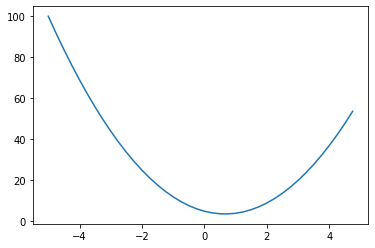

In [6]:
plt.plot(xs, ys)
plt.show()

We want to calculate the derivative of the function at each point. In this example, we can explicitly calculate the derivative of the function. However, this approach is not effective when it comes to neural networks. What is a derivative?<br> 

On a base level, this is a derivative:

*“Lets say I have a function y which is dependent on the value of x. If I nudge x just a tiny bit at a certain point, what would be the rate of change of y in response to that?”*

<u>Interpretation</u>: Derivatives indicate the rate of change of a function with respect to that variable surrounding an infinitesimally small region near a particular point:
Mathematically, a [derivative](https://en.wikipedia.org/wiki/Derivative) is shown below: 
<a id="c1"></a>
![mathematical definition of f(x) being differentiable at x](_imgs/differentiable_function.png)<br>
**Eq. 1: Mathematical definition of f(x) being differentiable at x.** ([Source](https://cs231n.github.io/optimization-2/))<br>


We give a slight bump to the variable x and check how the function responds to it. In eq. 1, we calculate the rate of change by dividing the difference between `f(x)` and `f(x+h)` (gotten from nudging `f(x)` by a tiny amount, `h`) by `h`, how much we nudged. Derivative shows the sensitivity of a function to a change in its variables. We will do a small numerical approximation of the derivative below.


In [7]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h

14.00000009255109

In [8]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

In [9]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

As seen above, if we take smaller and smaller h values, we can converge to the real gradient of **14, -22 and 0** @ **x = 3, -3 and 2/3** respectively. If the h value is infinitesimally small, then the gradient will be zero. <br>
At an optimal point (**x = 2/3**), the gradient is zero! The function won't change in any direction as a result of changing the input at that point.<br><br>
Suppose we have multiple input variables. Let's calculate the derivative of `d` WRT `c`.

In [10]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)
      

d1 4.0
d2 4.0001
slope 0.9999999999976694


Since **c** is a constant number, an infinitesimal or small change (*h*) in **c** will lead to that exact same change in **d**. Thus, the gradient/derivative is **one**. We can do the same for **a** and **b** to understand how **d** changes.

Next, lets discuss Micrograd, its creation, implementation and management. To deploy a neural network and leverage the Micrograd engine, we need separate data structures. 

---------
<br><br>
# 1. Micrograd: An Autograd Engine<a id="1"></a>
-------------------------------------------------------
<a id="d2"></a>
<u>Micrograd:</u> A tiny **autograd** (automatic gradient) engine that implements **backpropagation** (reverse-mode autodiff) over a dynamically built **DAG** (Directed Acyclic Graph) and a **small NNs library** on  top of it with a **PyTorch-like API**. It's a scalar-valued autograd-engine. Both python objects, the DAG and NN library, are tiny with ~100 and ~50 lines of code respectively. The DAG only operates over scalar values, so e.g. we chop up each neuron into all of its individual tiny adds and multiplies. However, this is enough to build up entire deep neural nets doing binary classification, as the demo notebook shows. <br><br>
Objectives for building **micrograd**:
1. Pedagogical/educational purposes
2. Understand neural networks (NNs)
3. Understand backpropagation (chain-rule & differentiation)
4. Understand the math being the same for scalars vs tensors <br>
    a. parallelism in computers runs tensors (array of scalars)<br>
    b. efficiency of using tensors
5. Needed to train NNs

In this notebook, we are going to build Micrograd - a minimalistic auto-differentiation (**autodiff**) engine in python. An autodiff/autograd algorithm forms the basis of modern neural network libraries like `PyTorch` and `Tensorflow` and works by automatically calculating gradients in computational graphs (DAGs such as NNs). This tutorial is inspired by this lecture - <u>"The spelled-out intro to neural networks and backpropagation: building micrograd"</u> - in Andrej Karpathy's [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html) lecture series. The full version of Micrograd (Andrej Karpathy) can be found on [github](https://github.com/karpathy/micrograd).

First thing we need to do is figure out a way to represent numbers and mathematical operations in Python to allow for different calculations to be done. In essence, we need a simple robust data structure to serve as a building block and connective tissue for our Micrograd engine.

Let’s develop a simple data structure (a core `Value` object) to manage the micrograd.

In [12]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self,), 'exp')
        
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # build the topological ordered list of all the children in the DAG
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
 
        # We must go through the topogical ordered list in the reverse order as per backpropagation
        # We must go through one variable at a time and
        # then apply the chain rule to get its gradient
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1


In [13]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')

e = a*b; e.label ='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0, grad=0.0)

In [14]:
print(f"The input nodes of L are {L._prev}")
print(f"The label of L is {L.label}")

The input nodes of L are {Value(data=4.0, grad=0.0), Value(data=-2.0, grad=0.0)}
The label of L is L


In [15]:
L._op

'*'

This class simply wraps the value and creates an object. Python uses `__repr__` function to internally represent the object. Without `__repr__`, the print function will print out the location of the object.<br>

We define addition using `__add__`. Whenever Python sees **a+b**, it internally executes `a.__add__(b)`. Other mathematical operators can also be defined in the same way.<br>

When initializing objects, the `_children` tuple is empty. However, when adding or multiplying, the previous elements are added to `_prev` set. Moreover, we need to know how a value was created (keep track of the mathematical operator involved). Thus, we introduce the `_op` attribute.

We add the `label`attribute to store the variable name/letter.

Now we need to visualize the graph DAG structure. Thus, we introduce the following code.



-------------
<br><br>
# 2. Micrograd: DAG Visualization<a id="2"></a>
-------------------------------------------------------

We need a function to help us visualize the computational graph built by the `Value` object.

In [16]:
import sys
print(sys.executable)

/Users/CEO/anaconda3/envs/py36/bin/python


In [17]:
import graphviz
graphviz.__version__, graphviz.version()

('0.19.1', (10, 0, 1))

In [18]:
from graphviz import Digraph

def trace(root):
    """
    builds a set of all nodes and edges in a graph
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph,create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

We created two functions: 
- `trace`: This function builds and stores a set of all the nodes and edges in a graph via recursion.
- `draw_dot`: This function takes a `Value` object and builds the computational graph associated with it. First, it recursively finds all the nodes and edges using the `trace` function and then continuously connect and draw these elements using the `graphviz` library.

So far, we've created a `Value` class that allows us to create a simple computational graph built of mathematical operators. We are also able to visualize this graph using the `graphviz` library. However to learn neural network parameters, we need to be able to calculate the gradients for each parameter in the computational graph with respect to the output node. Therefore, we need to understand backpropagation.

-------------
<br><br>
# 3. Micrograd: Backpropagation<a id="3"></a>
---------------------------------
<a id="d1"></a>
**Backpropagation** is far more general than the neural networks (NN). It is a gradient estimation mathematical machine used to train NNs. The gradient estimate is used by the optimization algorithm to compute the network parameter updates. It is also known as the [reverse mode of automatic differentiation](https://en.wikipedia.org/wiki/Backpropagation). Backpropagation is an algorithm created to efficiently evaluate the gradient of a loss function *wrt* the weights of a NN. 

It functions via iterative tuning of the NN weights (chain rule and differentiation implementation) to minimize the loss function and subsequently improve the accuracy of the NN. On a base level, it entails computing the gradient one layer at a time & iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule. Backprop is the mathematical core of any modern deep NN library like `PyTorch` or `JAX`.<br>


As a first step, let's calculate the gradients for each parameter of a simple expression manually below:





-------------
<br><br>
## 3.1. Manual Backpropagation example 001: simple expression<a id="301"></a>
-------------------------------------------------------
In backpropagation, we <u>recursively apply the chain rule backward through the computational graph</u>. 

Our function has 7 parameters: `a`, `b`, `c`, `d`, `e`, `f`, and `L`. Let us consider the gradients for each parameter with respect to the output `L`.

Functions:

\begin{align*}
a & = 2.0, \quad b = -3.0, \quad c = 10.0, \quad f = -2.0 \\
e & = a \cdot b \\
d & = e + c \\
L & = d \cdot f = 8.0 \\
\end{align*}

\begin{align*}
(a, b) & \rightarrow e \\
(e, c) & \rightarrow d \\
(d, f) & \rightarrow L \\
\end{align*}
Given:
\begin{align*}
\frac{dL}{dd} & = f = -2.0 \\
\frac{dL}{df} & = d = e + c = (a)(b) + c = (2)(-3) + 10 = 4.0 \\
\frac{dd}{dc} & = 1.0 \\
\frac{dd}{de} & = 1.0 \\
\frac{de}{da} & = b = -3.0 \\
\frac{de}{db} & = a = 2.0 \\
\end{align*}


We want:
\begin{align*}
\frac{dL}{dc} & = \frac{dL}{dd} \cdot \frac{dd}{dc} = -2.0 \cdot 1.0 = -2.0 \\
\frac{dL}{de} & = \frac{dL}{dd} \cdot \frac{dd}{de} = -2.0 \cdot 1.0 = -2.0 \\
\frac{dL}{da} & = \frac{dL}{de} \cdot \frac{de}{da} = \frac{dL}{de} \cdot b = -2.0 \cdot -3.0 = 6.0 \\
\frac{dL}{db} & = \frac{dL}{de} \cdot \frac{de}{db} = \frac{dL}{de} \cdot a = -2.0 \cdot 2.0 = -4.0 \\
\end{align*}



In [19]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')

e = a*b; e.label ='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0, grad=0.0)

In [20]:
L.grad = 1.0                  # dL/dL
f.grad = d.data               # dL/df
d.grad = f.data               # dL/dd
c.grad = e.grad = d.grad      # dL/dc, dL/de
a.grad = e.grad * b.data      # dL/da
b.grad = e.grad * a.data      # dL/db

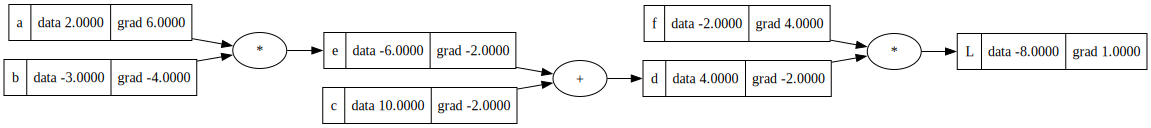

In [21]:
draw_dot(L)

----
The `grad_check` function below is used to understand how changes in the parameters (`input: var`) create a response in the output. It basically gives us the slope of L with respect to each parameter. We can change the step size, h, if we want but the default value is `h=0.001`.




In [22]:
def grad_check(var, h=0.001): #inline gradient check
    """
    parameters:
    
    var {string} : a,b,c,d,e,f
    h {float}: step change
    
    adjust a,b,c,d,e,f by h and see how it affects L 
    estimate dL/di, where i =  a,b,c,d,e,f
    """
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label ='e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data
    
    if var=='a':
        a = Value(2.0,label='a')
        a.data += h
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        L = d * f 
        L.label = 'L'
        L2 = L.data
    elif var=='b':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        b.data += h
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        L = d * f 
        L.label = 'L'
        L2 = L.data
    elif var=='c':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        c.data += h
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        L = d * f 
        L.label = 'L'
        L2 = L.data
    elif var=='d':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        d.data += h
        f = Value(-2.0, label='f')
        L = d * f 
        L.label = 'L'
        L2 = L.data
    elif var=='e':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        e.data += h
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        L = d * f
        L.label = 'L'
        L2 = L.data
    elif var=='f':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        f.data += h
        L = d * f
        L.label = 'L'
        L2 = L.data
    elif var=='L':
        a = Value(2.0,label='a')
        b = Value(-3.0,label='b')
        c = Value(10.0,label='c')
        e = a*b; e.label ='e'
        d = e+c; d.label = 'd'
        f = Value(-2.0, label='f')
        L = d * f
        L.data += h
        L.label = 'L'
        L2 = L.data
    else:
        print("The variable is NOT recognized !!! Ensure its one of these (case-sensitive): a, b, c, d, e, f, L")
        return None
    
    return (L2 - L1)/h

In [23]:
print(f"dL/dL = {grad_check('L'):.3f}")
print(f"dL/dd = {grad_check('d'):.3f}")
print(f"dL/df = {grad_check('f'):.3f}")
print(f"dL/dc = {grad_check('c'):.3f}")
print(f"dL/de = {grad_check('e'):.3f}")
print(f"dL/da = {grad_check('a'):.3f}")
print(f"dL/db = {grad_check('b'):.3f}")

dL/dL = 1.000
dL/dd = -2.000
dL/df = 4.000
dL/dc = -2.000
dL/de = -2.000
dL/da = 6.000
dL/db = -4.000


In [24]:
grad_check('df')

The variable is NOT recognized !!! Ensure its one of these (case-sensitive): a, b, c, d, e, f, L


-------------
<br><br>
## 3.2. Preview of a Single Optimization Step<a id="302"></a>
-------------------------------------------------------
If we nudge the variables in the direction of their gradients, it will increase L. This is the concept of **optimization**. Let’s try.

Now L=8.0000. Let’s change the input variables, in the direction of their gradient.

In [25]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b 
d = e + c
L = d * f

print(L.data)

-7.286496


After running the forward pass, `L=-7.286`. Here, 0.01 is the step size. Indeed we see that after we optimized our parameters using the gradients we manually calculated, and ran the forward pass of our network again, we managed to increase the value of L.

-------------
<br><br>
# 4. Micrograd: Neurons<a id="4"></a>

-------------
<br><br>
## 4.1. Biological Neuron vs. Artificial Neuron<a id="401"></a>
---------------------------------------
 
<a id="a1"></a>
<p align="center">
    <img src="_imgs/biological_neuron.png" width=480 height=240 align="left"> 
    <img src="_imgs/neuron_mathematical_model.jpeg" width=360 height=240 align="center"> 
</p>

**Fig 1. L-R: A Cartoon Diagram of a Biological Neuron & its Mathematical Model.** ([Source](https://cs231n.github.io/neural-networks-1/))


The figure above provides a side-by-side drawing of a biological and artificial neuron. The biological neuron is analogous to artificial neurons in the following terms:


|Biological Neuron  |Artificial Neuron          |
|-------------------|---------------------------|
|Cell Nucleus (Soma)|Node                       |
|Dendrites          |Input                      |
|Synapse            |Weights or interconnections|
|Axon               |Output                     |

## Artificial Neuron at a Glance
-----------------------------

The artificial neuron has the following characteristics:

*   A neuron is a mathematical function modeled on the working of biological neurons
*   It is an elementary unit in an artificial neural network
*   One or more inputs are separately weighted
*   Inputs are summed and passed through a nonlinear function to produce output
*   Every neuron holds an internal state called activation signal
*   Each connection link carries information about the input signal
*   Every neuron is connected to another neuron via connection link


In the next section, let us talk about perceptrons.

-------------
<br><br>
## 4.2. [Perceptron](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron#perceptron)<a id="402"></a>
------------

Perceptron was introduced by Frank Rosenblatt in 1957. He proposed a Perceptron learning rule based on the original MCP neuron. A Perceptron is an algorithm for supervised learning of binary classifiers. This algorithm enables neurons to learn and processes elements in the training set one at a time.


## Basic Components of Perceptron
------------------------------

Perceptron is a type of artificial neural network, which is a fundamental concept in machine learning. The basic components of a perceptron are:

1.  <u>Input Layer</u>: The input layer consists of one or more input neurons, which receive input signals from the external world or from other layers of the neural network.
2.  <u>Weights</u>: Each input neuron is associated with a weight, which represents the strength of the connection between the input neuron and the output neuron.
3.  <u>Bias</u>: A bias term is added to the input layer to provide the perceptron with additional flexibility in modeling complex patterns in the input data.
4.  <u>Activation Function</u>: The activation function determines the output of the perceptron based on the weighted sum of the inputs and the bias term. Common activation functions used in perceptrons include the step function, sigmoid function, and ReLU function.
5.  <u>Output</u>: The output of the perceptron is a single binary value, either 0 or 1, which indicates the class or category to which the input data belongs.
6.  <u>Training Algorithm</u>: The perceptron is typically trained using a supervised learning algorithm such as the perceptron learning algorithm or backpropagation. During training, the weights and biases of the perceptron are adjusted to minimize the error between the predicted output and the true output for a given set of training examples.
7.  Overall, the perceptron is a simple yet powerful algorithm that can be used to perform binary classification tasks and has paved the way for more complex neural networks used in deep learning today.

## Types of Perceptron models
--------------------------

We have already discussed the types of Perceptron models in the Introduction. Here, we shall give a more profound look at this:

1.  <u>Single Layer Perceptron model</u>: One of the easiest ANN (Artificial Neural Networks) types consists of a feed-forward network and includes a threshold transfer inside the model. The main objective of the single-layer perceptron model is to analyze the linearly separable objects with binary outcomes. A Single-layer perceptron can learn only linearly separable patterns.
2.  <u>Multi-Layered Perceptron **(MLP)** model</u>: It is mainly similar to a single-layer perceptron model but has more hidden layers.

<u>Forward Stage</u>: From the input layer in the on stage, activation functions begin and terminate on the output layer.

<u>Backward Stage</u>: In the backward stage, weight and bias values are modified per the model's requirement. The backstage removed the error between the actual output and demands originating backward on the output layer. A multilayer perceptron model has a greater processing power and can process linear and non-linear patterns. Further, it also implements logic gates such as AND, OR, XOR, XNOR, and NOR.



## [What is the Perceptron Model in Machine Learning?](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron#what_is_the_perceptron_model_in_machine_learning)
-------------------------------------------------

A machine-based algorithm used for supervised learning of various binary sorting tasks is called Perceptron. Furthermore, Perceptron also has an essential role as an Artificial Neuron or Neural link in detecting certain input data computations in business intelligence. A perceptron model is also classified as one of the best and most specific types of Artificial Neural networks. Being a supervised learning algorithm of binary classifiers, we can also consider it a single-layer neural network with four main parameters: **input values, weights and Bias, net sum, and an activation function.**

## How Does Perceptron Work?
-------------------------

As discussed earlier, Perceptron is considered a single-layer neural link with four main parameters. The perceptron model begins with multiplying all input values and their weights, then adds these values to create the weighted sum. Further, this weighted sum is applied to the activation function to obtain the desired output. This activation function is also known as the step function and is represented by f.

<a id="a2"></a>
![Perceptron_work](_imgs/perceptron.png)
**Fig 2. A single-layer Perceptron structure.** ([Source](https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53))

Mathematical representation of a single-layer neural network (**perceptron**) as shown in the figure above
1. All the inputs x are multiplied with their weights w
2. Add all the multiplied values including bias, (b or w_0) and call them Weighted Sum (W_s).
$$
W_s = \sum_{i=1}^{n} w_i.x_i + b \\ 
where\ b = w_0 \\
$$
3. Apply the correct Activation Function to that weighted sum.<br>

-------------
<br><br>
## 4.3. Activation Functions<a id="403"></a>
--------
The **[activation function](https://en.wikipedia.org/wiki/Activation_function)** of a node in an artificial neural network (ANN) is a function that calculates the output of the node based on its individual inputs and their weights. Nontrivial problems can be solved using only a few nodes if the activation function is *nonlinear*.

<a id="b1"></a>
Below is a table of different activation functions.
![Different Activation Functions](_imgs/activation_function_full.png)
**Table 1: Activation Functions.** ([Source](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions))<br><br>

Now let's look into an example of manual backpropagation using a neuron.

-------------
<br><br>
## 4.4. Micrograd: Manual Backpropagation Example 002: A Neuron<a id="404"></a>
-----------------------------

Let us discuss the basic structure of an artificial neuron. **Inputs, x** are multiplied by the corresponding **weights, w** and fed to the neuron. Internally, they are summed and then there is an extra term called **bias, b** which is added to yields the **Weighted sum, Ws**. The result is passed through the **activation function, f** (sigmoid, ReLU, tanh, Leaky ReLU, etc.) which yields an output. 

<a id="c2"></a>
$$
W_s = \sum_{i=1}^{n} w_i.x_i + b
$$
**Eq. 2: Mathematical representation of a NN weighted sum function.**<br>

Now, let us implement an artificial neuron and understand how to use backpropagation to tune its weights in order to train the neuron optimally. In the example below, we use the **tanh** activation function, which yields output in the range of -1 to 1. We can implement arbitrary complex functions if we know the local derivative. No need to break it down into atomic pieces. We will implement the `tanh` function under the class `Value` object.

In [26]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh() 
o.label = 'o'

Now we have implemented a complete neuron with two inputs: `x1` and `x2`.

Now when backpropagating, we need to find the local derivative of the `tanh` function.<br><br><br>
$$
o = \tanh(n) \\
\frac{do}{dn} = 1 - \tanh^2(n) \\
$$

Next, we can go through the exercise of manually calculating the `grad` values for each of the parameters: `x1`, `x2`, `w1`, `w2`, `x1w1`, `x2w2`, `x1w1 + x2w2`, `b` and `n`

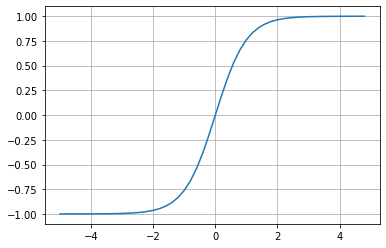

In [27]:
# tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [28]:
o.grad = 1.0
n.grad = 1 - o.data**2 # o = tanh(n); do/dn = 1 - tanh(n)**2 = 1 - o**2

#addition simply distributes the derivative
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

#we only need the derivatives of the weights
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [29]:
print(f"do/do = {o.grad:.3f}")
print(f"do/dn = {n.grad:.3f}")
print(f"do/db = {b.grad:.3f}")
print(f"do/d(x1w1 + x2w2) = {x1w1x2w2.grad:.3f}")
print(f"do/d(x1w1) = {x1w1.grad:.3f}")
print(f"do/d(x2w2) = {x2w2.grad:.3f}")
print(f"do/x2 = {x2.grad:.3f}")
print(f"do/w2 = {w2.grad:.3f}")
print(f"do/x1 = {x1.grad:.3f}")
print(f"do/w1 = {w1.grad:.3f}")

do/do = 1.000
do/dn = 0.500
do/db = 0.500
do/d(x1w1 + x2w2) = 0.500
do/d(x1w1) = 0.500
do/d(x2w2) = 0.500
do/x2 = 0.500
do/w2 = 0.000
do/x1 = -1.500
do/w1 = 1.000


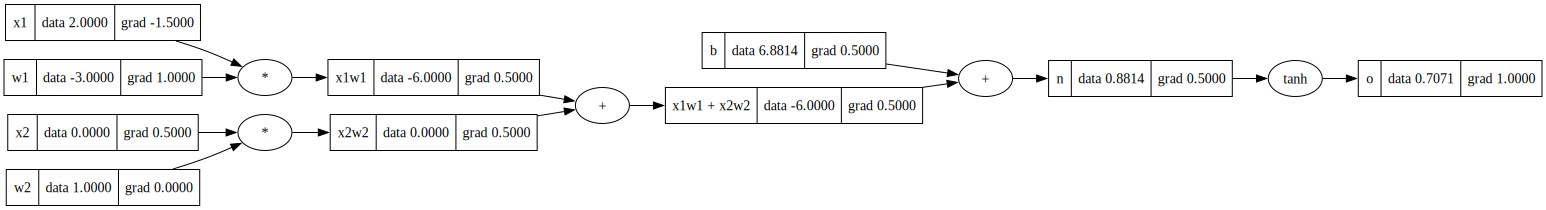

In [30]:
draw_dot(o)

Now, we understand how to do backpropagation. However, we cannot do this manual backpropagation to set the gradient for each parameter for highly complex neural networks like transformers with billions of parameters (**GPT-4 has ~1.76 trillion parameters**). This leads us to how to implement backpropagation automatically.

-------------
<br><br>
# 5. Micrograd: Implementing Backward Function for Each Operation<a id="5"></a>
-----------------
We are going to add `_backward` function to all the mathematical operations sub-functions (`__add__`, `__mul__`, `__pow__`, `tanh` and `exp`) in the class `Value` object. Now, there's no need to calculate the individual backpropagation gradient values manually. We can directly call the `_backward` method in the right order! This automatically calculates the gradients for each computational node.

In [31]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh() 
o.label = 'o'

In [32]:
o.grad = 1.0           #do/do (initialize to 1: agrees with the derivative too)

o._backward()          #do/dn
n._backward()          #do/db = do/d(x1w1+x2w2)
b._backward()          #b is a leaf node, so it does not have a _backward() function
x1w1x2w2._backward()   #do/d(x1w1) = do/d(x2w2)
x2w2._backward()       #do/d(x2), do/d(w2)
x1w1._backward()       #do/d(x1), do/d(w1)
#x1, w1, x2, w2 are leaf nodes, therefore they don't have _backward() functions

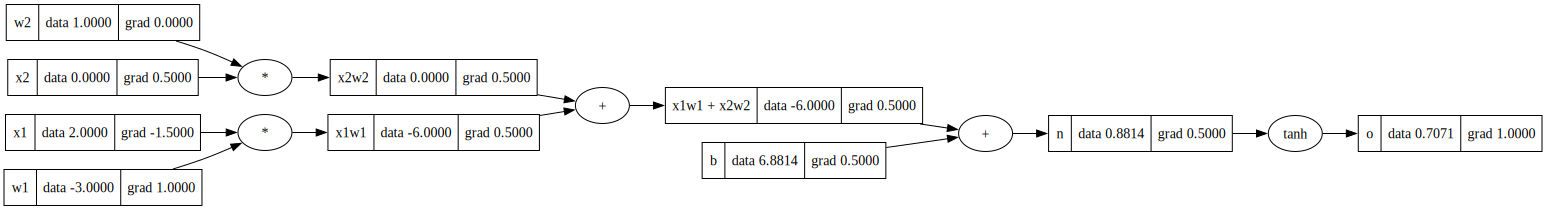

In [33]:
draw_dot(o)

Note that we had to set `o.grad = 1.0` manually. Why? Because the placeholder gradient value for each node is 0. The `_backward` function always depends on the previous gradient in the computational graph and if it was 0 then all gradients will turn out to be 0 (think about it).

But do we have to call the `_backward` function manually? Of course not! We can use a loop here, but notice that we need to iterate over the nodes in a certain order. We can’t call `_backward` on a node that has neighbors connected via outgoing edges whose gradients haven’t been calculated already. For this, we need something called topological sorting.

To calculate the gradient at a node in the neural network, its dependencies must be calculated before it. This can be achieved using **topological sort**. A layout of the graph structure whereby all the edges go only from left to right (L-R). In computer science, a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting) or topological ordering of a directed acyclic graph  **(DAG)** is a linear ordering of its vertices such that for every **directed edge UV** from **vertex U** to **vertex V**, <u>**U** comes before **V**</u> in the ordering. As a rule, **cyclic graphs** <u>don't have valid topological orderings.</u>


<a id="a3"></a>
![Toplogical Sort](_imgs/topological_sort.png)

**Fig 3. Topological Sort.** ([Source](https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95))<br><br>

For the directed graph represented in the above figure, this is one of the topological sort for the DAG:
* A → B → C → D → G → F → E. 

To put it simply, in a topological order of vertices, there will be no edge pointing backward in its linear representation of all vertices. 
Until now in the `Value` class, we have devised mathematical operation functions with their individual `_backward` methods. Each operation can backpropagate the flowing gradients to its children only.
Now, we can create a global `backward` method in `Value` class that leverages topological sorting via an internal local `build_topo` function to iterate over all such mathematical functions in a DAG (built equation) and back-propagate the gradient over the entire computational graph. This function works by:

- sorting the DAG in a topological order using `build_topo`
- storing the topologically sorted list
- setting the `grad` of the last node to 1.0
- iterating over the topologically sorted list in reverse order (backpropagation: reverse differentiation) and applying the `_backward` method of each mathematical operation.

In [34]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh() 
o.label = 'o'

In [35]:
o.backward()

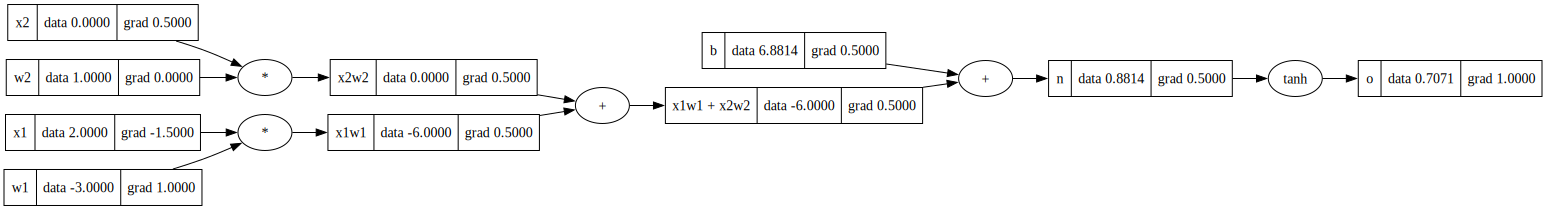

In [36]:
draw_dot(o)

-------------
<br><br>
# 6. Micrograd: Fixing a Backprop Bug when One Node is Used Multiple Times<a id="6"></a>
-----------------

Problem arises when a variable/node in the DAG is used more than once due to our current implementation of `Value`. Let's see in the example below  

<u>Note:</u> Since the class `Value` object is updated in a cell above, the example below will give the right answer upon restarting the notebook after the class `Value` object has been updated to account for **accumulation of gradients**. This example was to show the initial bug issue prior to the update of the `Value` class object.

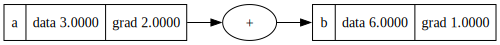

In [37]:
a = Value(3.0, label = 'a')
b = a + a ; b.label ='b'
b.backward()
draw_dot(b)

The gradient of b WRT a (`a.grad` or `db/da`) in the cell above should be 2 but the answer above is 1 which is wrong. We have just propagated the gradient of the output to the input. We have given only one object as the input. Thus, the gradient machine ignores the second instance of the same input object. **We will get a wrong answer whenever we use a variable more than once unless we fix the bug.**

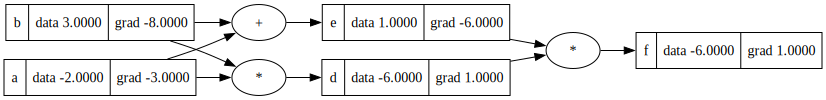

In [38]:
a = Value(-2.0,label='a')
b = Value(3.0,label='b')


d = a * b   ; d.label ='d'
e = a + b   ; e.label = 'e'
f = d * e   ; f.label='f'

f.backward()

draw_dot(f)

----------
<br><br>
## 6.1.  Multivariate Chain Rule for Derivatives<a id="601"></a>
-----
The solution is that the gradients must be **accumulated** as we propagate from the output to each parameter node. This is derived from the [**multivariate chain rule.**](https://en.wikipedia.org/wiki/Chain_rule#Example) Let's show an [example below](https://machinelearningmastery.com/the-chain-rule-of-calculus-even-more-functions/).<br><br>
$$
h=g(r,s,t)=r^2-rs+t^3 \\
r = x \cos y \\ s = xe^y \\ t = x+y \\
$$

<a id="c3"></a>
Implementing the chain rule here requires the computation of partial derivatives, since we are working with multiple independent variables. Furthermore, $r$, $s$ and $t$ will also act as our intermediate variables. The formulae that we will be working with, defined with respect to each input, are the following:
![multivariate chain rule](_imgs/multivariate_chain_rule.png)

From these formulae, we can see that we will now need to find nine different partial derivatives. Again, we proceed to substitute these terms in the formulae for $\partial h/\partial x$ and $\partial h/\partial y$:
![multivariate chain rule1](_imgs/multivariate_chain_rule1.png)

And subsequently substitute for $r$, $s$ and $t$ to find the derivatives:
![multivariate chain rule2](_imgs/multivariate_chain_rule2.png)

Which may be simplified a little further (hint: apply the trigonometric identity $2\sin y\cos y=\sin 2y$ to $\partial h/\partial y$):
![multivariate chain rule3](_imgs/multivariate_chain_rule3.png)<br><br>

In backpropagation, the gradient of a certain node will be calculated additively — the effects of all calculations will add up. In the class `Value` object, we replace `=` with `+=` in the `self.grad` and `other.grad` calculations under the local `_backward` method in `__add__`, `__mul__`, and `tanh` functions to reflect this accumulation of gradients that follows the multivariate chain rule. Now, we should get the **correct answer for the gradients** for the examples below.

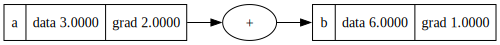

In [39]:
a = Value(3.0, label = 'a')
b = a + a ; b.label ='b'
b.backward()
draw_dot(b)

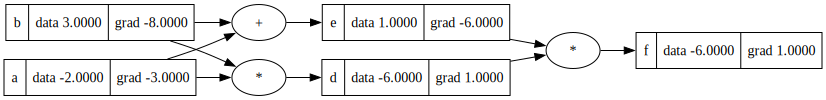

In [40]:
a = Value(-2.0,label='a')
b = Value(3.0,label='b')


d = a * b   ; d.label ='d'
e = a + b   ; e.label = 'e'
f = d * e   ; f.label='f'

f.backward()

draw_dot(f)

-------------
<br><br>
# 7. Micrograd: Adding More Mathematical Operations<a id="7"></a>
-----------------

Now let’s further develop our `Value` class object by adding more functionality and operations. Operations that are added include `__rmul__`, `__pow__`, `__truediv__`, `__neg__`, `__sub__`, `exp` and other operators needed.<br><br>
Also, we can handle constants like 1 in **a + 1** by adding the following line of code (which takes care of 1 by wrapping it as a `Value` object) to the `__add__` function:`other = other if isinstance(other, Value) else Value(other)`.<br><br>
We can handle **1 + a** by calling the `__radd__` operator to avoid pythonic issues from default calling of `__add__`(`1.__add__(a)`) which doesn't know how to deal with `Value` objects that are user-defined. If python fails to call `__add__` for some reason and `__radd__` is available, it will swap the operands of `__add__` and call `__radd__`. Thus, **1 + a** will become **a + 1** and python will call this instead. The same logic applies for `__mul__` and `__rmul__`.


In [41]:
a = Value(2.0)
b = Value(4.0)
a+1

Value(data=3.0, grad=0.0)

In [42]:
a*1

Value(data=2.0, grad=0.0)

In [43]:
2*a

Value(data=4.0, grad=0.0)

In [44]:
a.exp()

Value(data=7.38905609893065, grad=0.0)

In [45]:
a/b

Value(data=0.5, grad=0.0)

In [46]:
a * 1/b

Value(data=0.5, grad=0.0)

In [47]:
a * (b**-1)

Value(data=0.5, grad=0.0)

In [48]:
a-b

Value(data=-2.0, grad=0.0)

In [49]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh() 
o.label = 'o'
o.backward()

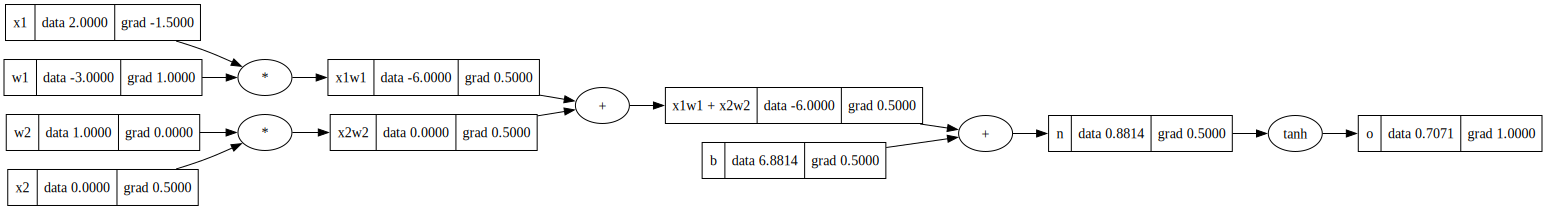

In [50]:
draw_dot(o)

-------------
<br><br>
## 7.1. Breaking up `tanh` Function into its Parts<a id="701"></a>
-----------------------------
Currently, our `Value` class supports the `tanh` operation as a complete block. What if we wanted to break it into its constituting parts by explicitly including the tanh calculation in a computational graph?

To achieve `tanh` implementation, we need the following operators: 
1. exponentiation (`exp`)
2. power (`__pow__`)
3. division (`__truediv__`, `__rdiv__`)
4. multiplication (`__mul__`, `__rmul__`) 
5. subtraction (`__neg__`, `__sub__`)
6. addition (`__add__`, `__radd__`)

Most of the listed operators above have already been added to our `Value` object. The rest will be implemented in our `Value` object. Now, we can break up the `tanh` function into its parts, such that the complete calculation is visualized in the computational DAG as shown below.

In [51]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
# -----------
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ------------
o.label = 'o'
o.backward()

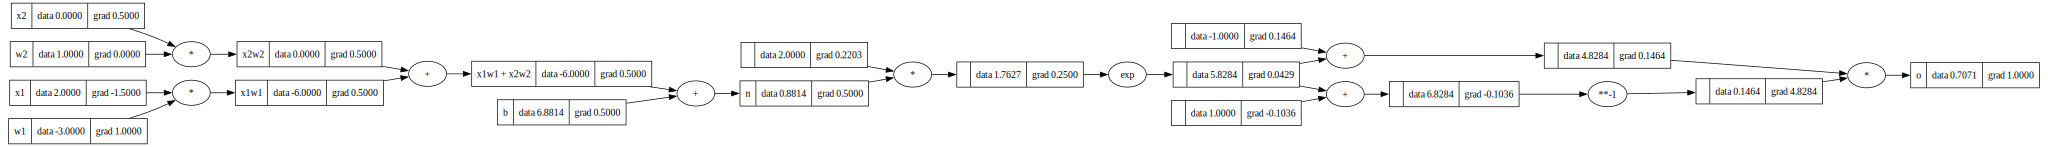

In [52]:
draw_dot(o)

<br><br>
# 8. Micrograd: A [`PyTorch`](https://pytorch.org/tutorials/) Comparison<a id="8"></a>
-----------------

We can use [**PyTorch**](https://pytorch.org/docs/stable/index.html) to run the same architecture we implemented. We developed our own <u>autograd computational graph object</u> (`Value`) and validated its functionality as a data structure representation and a backpropagation supportive engine for arbitrarily complex DAGs. 
- PyTorch uses <u>n-dimensional tensors</u> as their basic data structure. Thus, to define a scalar, we use one-dimensional tensors.

- **PyTorch** uses <u>single precision values</u> (`torch.float32`). However, **Python** uses <u>double-precision values</u> (`torch.float64`). Thus, for consistency, we use the `.double()` function to typecast PyTorch values.

- PyTorch by default does not calculate the gradients. Thus, we must explicitly state that the variables require gradients and we must calculate them. <br>
    1. `var.requires_grad=True`: This indicates that the gradients with respect to **var** will be computed during backpropagation.
    2. `var.grad_item()`: Returns the value of the `var.grad` tensor as a standard Python number. This only works for tensors with one element.<br>

To validate our implementation of Micrograd, we will implement the exact same computational graph from before in Pytorch and confirm that the results are identical. Run the following Python code cells below to see PyTorch in action. <br>

In [53]:
import sys
print(sys.executable)

/Users/CEO/anaconda3/envs/py36/bin/python


In [54]:
import torch

In [55]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]),\
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 torch.Size([2, 3]))

In [56]:
torch.tensor([2.0]).dtype,\
torch.tensor([2.0]).double().dtype 

(torch.float32, torch.float64)

In [57]:
x1 = torch.tensor([2.0]).double()     ;x1.requires_grad=True
w1 = torch.tensor([-3.0]).double()    ;w1.requires_grad=True
x2 = torch.tensor([0.0]).double()     ;x2.requires_grad=True
w2 = torch.tensor([1.0]).double()     ;w2.requires_grad=True
b  = torch.tensor([6.8813735870195432]).double()     ;b.requires_grad=True
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [58]:
o, o.item(), o.data.item()

(tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>),
 0.7071066904050358,
 0.7071066904050358)

-------------
<br><br>
# 9. Micrograd: Building a NN Library (Multi-Layer Perceptron, MLP)<a id="9"></a>
-----------------

## 9.1. [Neural Network architectures (cs231n)](https://cs231n.github.io/neural-networks-1/)<a id="901"></a>
-------
### Layer-wise organization
-------
**Neural Networks as neurons in graphs**. Neural Networks are modeled as collections of neurons that are connected in an acyclic graph. In other words, the outputs of some neurons can become inputs to other neurons. Cycles are not allowed since that would imply an infinite loop in the forward pass of a network. Instead of an amorphous blobs of connected neurons, Neural Network models are often organized into distinct layers of neurons. For regular neural networks, the most common layer type is the **fully-connected layer** in which neurons between two adjacent layers are fully pairwise connected, but neurons within a single layer share no connections. Below are two example Neural Network topologies that use a stack of fully-connected layers:

<a id="a4"></a>
<p align="center">
    <img src="_imgs/MLP_2layer.jpeg" width=340 height=240 align="left"> 
    <img src="_imgs/MLP_3layer.jpeg" width=480 height=240 align="center"> 
</p>


**Fig 4. L-R: A Diagram of Two Multi-Layer Perceptrons (MLP): a 2-layer NN, a 3-layer NN.** ([Source](https://cs231n.github.io/neural-networks-1/))<br>

Left: A **2-layer NN** (one hidden layer of 4 neurons (or units) and one output layer with 2 neurons), and three inputs. <br>Right: A **3-layer NN** with three inputs, two hidden layers of 4 neurons each and one output layer. <br>Notice that in both cases there are connections (synapses) between neurons across layers, but not within a layer. <br><br>

**Naming conventions.** Notice that when we say N-layer neural network, we do not count the input layer. Therefore, a single-layer neural network describes a network with no hidden layers (input directly mapped to output). In that sense, you can sometimes hear people say that logistic regression or SVMs are simply a special case of single-layer Neural Networks. You may also hear these networks interchangeably referred to as _“Artificial Neural Networks”_ (ANN) or _“Multi-Layer Perceptrons”_ (MLP). Many people do not like the analogies between Neural Networks and real brains and prefer to refer to neurons as _units_.

**Output layer.** Unlike all layers in a Neural Network, the output layer neurons most commonly do not have an activation function (or you can think of them as having a linear identity activation function). This is because the last output layer is usually taken to represent the class scores (e.g. in classification), which are arbitrary real-valued numbers, or some kind of real-valued target (e.g. in regression).

**Sizing neural networks**. The two metrics that people commonly use to measure the size of neural networks are the number of neurons, or more commonly the number of parameters. Working with the two example networks in the above picture:

*   The first network (left) has 4 + 2 = 6 neurons (not counting the inputs), \[3 x 4\] + \[4 x 2\] = 20 weights and 4 + 2 = 6 biases, for a total of 26 learnable parameters.
*   The second network (right) has 4 + 4 + 1 = 9 neurons, \[3 x 4\] + \[4 x 4\] + \[4 x 1\] = 12 + 16 + 4 = 32 weights and 4 + 4 + 1 = 9 biases, for a total of 41 learnable parameters.

To give you some context, modern Convolutional Networks contain on orders of 100 million parameters and are usually made up of approximately 10-20 layers (hence _deep learning_). However, as we will see the number of _effective_ connections is significantly greater due to parameter sharing. More on this in the Convolutional Neural Networks module.<br><br>

Now let’s develop the machinery to create a small neural network.
First, we define a class to implement a single neuron. Then we build the layer. And finally, we create an MLP. The breakdown of each class object is stated below:

- Class `Neuron` contains code for a computational unit that receives `nin` inputs and outputs the result of a **tanh** operation on a weighted sum of the inputs plus a bias term.


- Class `Layer` aggregates several neurons such that it takes certain data as input (of size `nin`) and passes it through `nout` neurons. We do a small check in the end where if the output contains only one neuron we return it as-is and not in a list.


- Class `MLP` is the final abstraction in which we aggregate `nout` instances of `Layer` by passing the input data `x` through each of them in succession.

For each class, we added a `parameters` function that collects all trainable parameters. This will come in handy later when we train the network.

In [59]:
import random

class Neuron:
    """ Defines a single neuron"""

    def __init__(self, nin):
        """ Assign random weights and biases to the inputs 
        Parameters
        ----------
        nin: int
            inputs to the neuron
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): # w * x + b
        """ Calculate the output of the neuron
        Parameters
        ----------
        x: list
            input values to the neuron

        Returns
        ----------
        integer
            output of the neuron
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)),  self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    """ Defines a layer of neurons """

    def __init__(self, nin, nout):
        """ Initialize the neurons of the layer
        Parameters
        ----------
        nin: int
            number of inputs to the layer
        nout: int
            number of neurons in the layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        """ Calculate the outputs of a layer
        Parameters
        ----------
        x: list
            input values to the neuron

        Returns
        ----------
        int
            outputs of the neuron
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
    
class MLP:
    """ Defines a multilayer perceptron"""
    
    def __init__(self, nin, nouts): # nout define the sizes of all layers
        """ Initialize the layers of MLP
        Parameters
        ----------
        nin: int
            number of inputs to the MLP
        nouts: list
            number of neurons in each layer
        """
        sz = [nin] + nouts
        self.layers= [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        """ Calculate the outputs of a layer sequentially
        Parameters
        ----------
        x: list
            input values to the MLP

        Returns
        ----------
        list
            outputs of the MLP 
        """
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [60]:
x = [2.0, 3.0]
a = Neuron(2)
a(x)

Value(data=0.9105848567129079, grad=0.0)

In [61]:
x = [2.0, 3.0]
b =  Layer(2, 3)
b(x)

[Value(data=0.9835475868478987, grad=0.0),
 Value(data=-0.18080027900666776, grad=0.0),
 Value(data=-0.36304820207442917, grad=0.0)]

In [62]:
# inputs to the nn
x = [2.0, 3.0, -1.0]

# initialize the MLP
n = MLP(3, [4, 4, 1])

# run the NN
n(x)

Value(data=-0.03132176728538012, grad=0.0)

In [63]:
len(n.parameters())

41

-----------
<br><br>
# 10. Micrograd: Creating a Tiny Dataset & Writing the Loss Function<a id="10"></a>
-----------------
Now let’s create a tiny data set. We have **inputs** and **desired targets**. We will run the neural network in the forward direction. This is a **small, simple binary classification problem**.

In [64]:
xs =[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

#target values (simple binary classification)
ys =[1.0, -1.0, -1.0, 1.0]

#run the neural network on all the inputs
# ypred = [n(x) for x in xs]
# ypred

<a id="c4"></a>
We want the neural network to generate predicted values that are as close to the target values as possible. We should tune the weights. But how???

- **Backpropagation !!!**

Before that, we must calculate a single number (loss) to measure the network's performance. There are various loss functions (mean squared error, binary cross-entropy loss, etc.) that can be used. We use the mean squared error (MSE) function as the loss function. Our goal is to minimize the loss function so as to improve model performance.

![MSE](_imgs/MSE.png)
**Eq. 4: Mean Squared Error (MSE)** ([Source](https://en.wikipedia.org/wiki/Mean_squared_error))

In [65]:
ypred = [n(x) for x in xs]
loss = 0
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2 
print(loss)

Value(data=5.625114897319604, grad=0.0)


In [66]:
'''loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = y_ground_truth, yout = y_output
loss''' #it affects operations due to Value object representation of parameters (error: int + Value)

'loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = y_ground_truth, yout = y_output\nloss'

-----------
<br><br>
# 11. Micrograd: Neural Net Parameters<a id="11"></a>
-----------------
Now, we've calculated the loss function, and all the gradients of the loss function. However, the gradients WRT inputs are only useful if the inputs are assumed to be fixed. We need to collect all the parameters we can change. We can add a `parameter` method to the `neuron`, `layer`, and `MLP` class modules above which collects all trainable parameters. This will come in handy later when we train the network.


In [67]:
n.layers[0].neurons[0].w[0].grad

0.0

In [68]:
n.layers[0].neurons[0].w[0].data

-0.3188397214186136

We need to update parameters according to their gradient information. **The gradient** is a vector that points towards the increasing direction of loss. Thus, we must move in the opposite direction of the gradient.


Finally! We are going to train our neural network to fit the dummy data points we showed before. To train our net we need to repeat the **forward pass -> loss calculation -> backward pass** procedure. We do it manually in the cells below. 

In [69]:
ypred = [n(x) for x in xs]
loss = 0
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2 
print(loss)

Value(data=5.625114897319604, grad=0.0)


In [70]:
loss.backward()

In [71]:
for p in n.parameters():
    p.data += -0.05 * p.grad

In [72]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.5438762632690177, grad=0.0),
 Value(data=0.5956186061958746, grad=0.0),
 Value(data=-0.4498238385421293, grad=0.0),
 Value(data=0.5037095702051143, grad=0.0)]

-----------
<br><br><a id="12"></a>
# 12. Micrograd: Manual Gradient Descent Optimization & Training the MLP
-----------------

<a id="d3"></a><u>Gradient Descent:</u><br>
Now, we encounter gradient descent (G.D.) for optimization. [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a method for unconstrained mathematical optimization. It is a first-order iterative algorithm for finding a local minimum of a differentiable multivariate function.

The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent.It is particularly useful in machine learning for minimizing the cost or loss function. To reach the lowest point on the surface we start taking steps along the direction of the steepest downward slope. This is what the gradient descent algorithm achieves during each training epoch or iteration.<br><br>
<u>Steps for implementing gradient descent:</u>

Iterate a certain number of times (**n_iter**): 
1. <u>Forward Pass</u>: We compute the predictions from the inputs using `MLP`. Then we compute the loss from the target and predicted values using Mean-Squared Error (MSE) loss function.
2. <u>Backward Pass</u>: We reset the gradients of the NN to zero and perform backpropagation on our NN MLP model.
3. <u>Parameter Update</u>: We update the parameters (weights and biases) of our `MLP` with the gradient information.

 
Neural networks can be trained by:
1. Constructing an instance with the desired architecture
2. Calling on inputs to make predictions
3. Calculating loss between predictions and targets
4. Calling a method to calculate gradients
5. Calling a method to update parameters
6. Repeating steps 2-5 over many batches of training data (**Gradient Descent Optimization**)

Instead of manually training the MLP like we did in the previous section, we can write a simple `train_MLP` function that implements the training loop for us.

In [73]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6041503111538816, grad=0.0)

In [74]:
xs =[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

#target values (simple binary classification)
ys =[1.0, -1.0, -1.0, 1.0] 

In [75]:
def train_MLP(n_iter=20, learning_rate=0.01):
    losses, steps = [], []
    step = 0
    for k in range(n_iter):
        step += 1
        steps.append(step)
        # forward pass
        ypred = [n(x) for x in xs]
        loss = 0
        for ygt, yout in zip(ys, ypred):
            loss += (yout - ygt)**2 
        total_loss = loss
        losses.append(total_loss.data)

        # backward pass -> reset gradients to zero so as to
        # ensure the actual backward pass accumulates the loss derivatives into the gradients
        for p in n.parameters():
            p.grad = 0.0
        total_loss.backward()

        # update parameters
        for p in n.parameters():
            p.data += -1 * learning_rate * p.grad

        print(k, total_loss.data)
    print(ypred)
    return [steps, losses]

In [76]:
_train_loss = train_MLP(40, 0.05)

0 5.485189247043687
1 3.3421234365691754
2 2.584049020397665
3 1.9610887856041734
4 1.4208451979993688
5 0.9652687705981344
6 0.6646346234265398
7 0.47428422790045377
8 0.3615123589435135
9 0.2870300719366895
10 0.23489049651030347
11 0.19691204612563087
12 0.16831557271479816
13 0.14617933935615032
14 0.12864178050918224
15 0.1144722088955907
16 0.10283027925617594
17 0.09312577909436154
18 0.08493384323191937
19 0.07794195214308396
20 0.071915798959111
21 0.066676715938482
22 0.06208638656923887
23 0.05803626867652136
24 0.0544401349246291
25 0.051228719740150565
26 0.048345816790658386
27 0.04574539276626418
28 0.043389424538740215
29 0.041246258705737185
30 0.03928935342896755
31 0.037496303502279935
32 0.03584807765559297
33 0.03432841658324537
34 0.032923353888887105
35 0.03162083189798568
36 0.03041039131962961
37 0.029282918859381307
38 0.028230440651596557
39 0.027245952177094315
[Value(data=0.9311099191634069, grad=-0.13778016167318619), Value(data=-0.9800438376407024, grad=0

In [77]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9322752068220904, grad=0.0),
 Value(data=-0.9804343270784147, grad=0.0),
 Value(data=-0.885414663220842, grad=0.0),
 Value(data=0.9093136457027569, grad=0.0)]

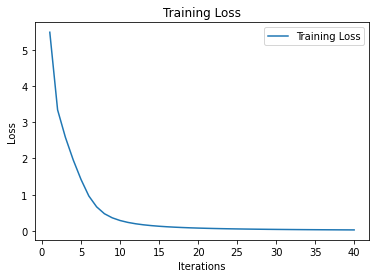

In [78]:
# Retrieve each dictionary's values
train_values = _train_loss[1]
 
# Generate a sequence of integers to represent the iteration numbers
n_iter = _train_loss[0]
 
# Plot and label the training and validation loss values
plt.plot(n_iter, train_values, label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(np.arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

A [common bug](https://twitter.com/karpathy/status/1013244313327681536?lang=en) encountered during training of a neural network is <u>forgetting to clear the gradient information of the parameters from the computational graph</u>. Remember that as we calculate the gradients for the different components of the graph, we use `+=` instead of `=` to accumulate gradient information because a certain node may be used more than once in the graph and to get its correct gradient we need to sum up all of the contributions to the gradient.

In the manual implementation in the prior section, we forgot to clear the gradient value, so the gradient will get accumulated through subsequent forward passes — which were performed with different network weights! This makes no sense, of course, so as a simple fix, we need to set the gradients to zero or use `.zero_grad()` in PyTorch before `.backward`.



-----------
<br><br>
# 13. Micrograd: Summary<a id="13"></a>
-----------------

The summary below encapsulates the concepts discussed, covering the basics of neural networks, and their training process. Furthermore, the building and implementation of **Micrograd**, an autograd engine, helps in the understanding & reinforcement of the fundamental principles behind neural networks and backpropagation. Summary points include:


- **Neural Networks (NNs)**: 

  - Neural networks are mathematical expressions used for processing data.

  - They are composed of simple mathematical operations.

  - In the case of a multi-layer perceptron, they take input data along with weights and parameters.

- **Forward Pass and Loss Function**:

  - The forward pass involves applying the neural net's mathematical expression to the input data.

  - This is followed by evaluating a loss function, which measures the accuracy of predictions.

  - Lower loss indicates better performance, where predictions align closely with targets.

- **Backpropagation and Gradient Descent**:

  - Backpropagation is used to compute gradients, indicating how each parameter affects the loss.

  - Gradients guide the adjustment of parameters to minimize the loss.

  - Gradient descent iteratively updates parameters to minimize the loss function.

- **Power and Complexity**:

  - Neural networks possess significant power, capable of addressing complex problems.

  - They can have billions or even trillions of parameters, forming a complex network.

  - Despite complexity, they operate on fundamental principles of gradient descent and loss minimization.

- **NNs Emergent Properties**:

  - Neurons within neural networks exhibit emergent properties when solving challenging problems.

  - Properties arise from interactions within the network during training.

- **Application in Language Modeling**:

  - Neural networks are extensively used in language modeling tasks like predicting the next word in a sequence.

  - Even large-scale models like GPT utilize the same fundamental principles of neural network training.

  - Although more complex, they rely on gradient descent and loss minimization.

- **Fundamental Principles**:

  - While specific implementations may vary, the fundamental principles of neural network training remain consistent.

  - Updates may include variations in gradient descent techniques (stochastic G.D., etc.) and loss functions (cross_entropy_loss, etc.) tailored to specific tasks.

  - Despite variations, the core concepts of neural network training remain universal.

- **Understanding and Implementation**:

  - By understanding the foundational principles of neural networks, one can grasp their workings intuitively.

  - Learning about neural networks' inner workings allows for better comprehension and implementation of related concepts.<br><br>


-----
<br><br><a id="r1"></a>
# References
----
1. "<u>The spelled-out intro to neural networks and backpropagation: building micrograd</u>" [youtube video](https://www.youtube.com/watch?v=VMj-3S1tku0), Aug 2022.
2. Andrej Karpathy **Micrograd** [github repo](https://github.com/karpathy/micrograd).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebooks](https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd) to follow video tutorial with).
4. Andrej Karpathy **Micrograd** follow-up [excercises](https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing) for practice.
5. Article: "<u>Backpropagation with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/thedeephub/backpropagation-with-andrej-karpathy-part-1-916bc9bb54d8), [2](https://medium.com/thedeephub/backpropagation-with-andrej-karpathy-part-2-291a70069dd6), [3](https://medium.com/@kdwa2404/backpropagation-with-andrej-karpathy-part-3-717642087c34), Feb 2024.
6. "<u>Back(prop) to Basics — Fundamentals of Neural Networks</u>" - Elad Rapaport, [article](https://medium.com/@erap129/back-prop-to-basics-fundamentals-of-neural-networks-d54cd8fc61e4), May 2023.
7. "<u>What is Perceptron: A Beginners Guide</u>" - Mayank Banoula, [article](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron#:~:text=The%20perceptron%20model%20begins%20with,and%20is%20represented%20by%20'f.), May 2023.
8. "<u>What the Hell is Perceptron? The Fundamentals of Neural Networks</u>" - Sagar Sharma, [article](https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53), Sept 2017.
9. "<u>Topological Sort: In Typescript and C#</u>" - Harish Reddy Konduru, [article](https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95), June 2020.
10. "<u>Automatic Differentiation Part 2: Implementation Using Micrograd</u>" - Aritra Roy Gosthipaty & Ritwik Raha, [article](https://pyimagesearch.com/2022/12/26/automatic-differentiation-part-2-implementation-using-micrograd/), Dec 2022.
11. "<u>The Chain Rule of Calculus – Even More Functions</u>" - Stefania Cristina, [article](https://machinelearningmastery.com/the-chain-rule-of-calculus-even-more-functions/), March 2022.
12. CS231n Convolutional Neural Networks for Visual Recognition [course website](https://cs231n.github.io/)
13. CS231n "<u>Neural Networks Part 1: Setting up the Architecture</u>" [lecture notes](https://cs231n.github.io/neural-networks-1/)
14. Wikipedia: [derivative](https://en.wikipedia.org/wiki/Derivative), [backpropagation](https://en.wikipedia.org/wiki/Backpropagation), [activation function](https://en.wikipedia.org/wiki/Activation_function), [topological sorting](https://en.wikipedia.org/wiki/Topological_sorting), [multivariate chain rule](https://en.wikipedia.org/wiki/Chain_rule#Example), [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
15. PyTorch Documentation [link](https://pytorch.org/docs/stable/index.html).
16. OpenAI [chatGPT](https://chat.openai.com/): Helped in preparing [**Section 13. Micrograd: Summary**](#13) notes
